# Time Series Modeling

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from csv import reader, writer
from datetime import datetime as dt
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [3]:

os.chdir('data')

In [3]:
## this dataframe left dep_delay with negative values
with open('ca_df.pickle','rb') as read_file:
    ca_df = pickle.load(read_file)

In [4]:
with open('ca_yrs_df.pickle','rb') as read_file:
    ca_yrs_df = pickle.load(read_file)

In [5]:
# delay by full datetime (date + time)
#yrs_delay_df = ca_yrs_df[['datetime','dep_delay']]
ca_yrs_df.set_index('datetime',inplace=True)

In [6]:
ca_df['date'] = pd.to_datetime(ca_df['fl_date'])
ca_df.set_index('date', inplace=True)

In [7]:
# then calculate the delta in time plus one (inclusive of first day)
ca_df.index.max() - ca_df.index.min()

Timedelta('364 days 00:00:00')

In [8]:
# pivot table of average dep_delay with rows=month and cols as origin or not
pt = ca_df.pivot_table(index='month', columns='origin', values='dep_delay')
pt

origin,LAX,SFO,SJC
month,,,
1,6.516806,8.760395,4.754191
2,7.157724,5.467100,7.641923
3,12.652407,13.109089,7.811438
4,9.162851,8.617201,8.924537
5,8.358413,13.798750,8.409139
6,8.160412,12.980369,6.802649
7,9.829327,10.019414,8.423223
8,10.282799,19.055336,9.012810
9,4.214891,5.181306,4.723285


<Figure size 1440x720 with 0 Axes>

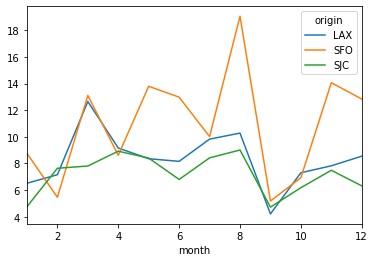

<Figure size 1440x720 with 0 Axes>

In [9]:
# plot average sales by month and origin
pt.plot();
plt.figure(figsize=(20,10))

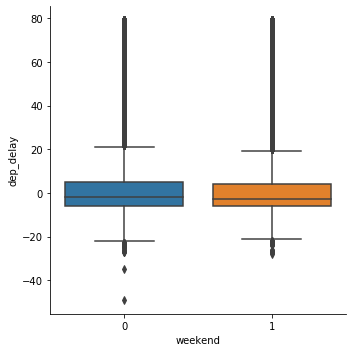

In [10]:
# do weekends affect delays?
sns.catplot(
    x='weekend',
    y='dep_delay',
    data=ca_df[ca_df['dep_delay'] <80],
    kind='box');

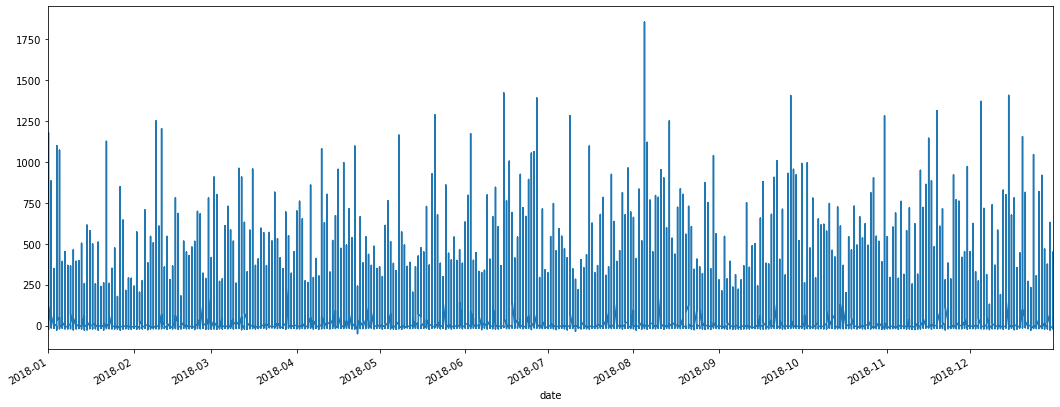

In [11]:
ca_df.dep_delay.plot(figsize=(18,7));

## Daily Average

In [ ]:
daily_average_delay = ca_yrs_df.dep_delay.resample('D').mean()

In [12]:
daily_average_delay = ca_df.dep_delay.resample('D').mean()

daily_average_delay.head(10)

date
2018-01-01    15.714022
2018-01-02    14.131944
2018-01-03     5.697133
2018-01-04     7.332692
2018-01-05    16.609290
2018-01-06     7.934409
2018-01-07    13.708029
2018-01-08    17.715485
2018-01-09    13.874387
2018-01-10    10.867377
Freq: D, Name: dep_delay, dtype: float64

In [13]:
# check autocorrelation for previous two weeks
for i in range(1,16):
    print(i, daily_average_delay.autocorr(lag=i))

1 0.3880438484992574
2 0.19164924037624606
3 0.17052900562548381
4 0.19075360232123384
5 0.20190748395754934
6 0.2456548074177703
7 0.24887158531769402
8 0.16977741626500806
9 0.09561373103847041
10 0.19048193776693845
11 0.09529803206114286
12 0.03757197225444635
13 0.06928195058329999
14 0.06586566874004816
15 0.09187312129583598


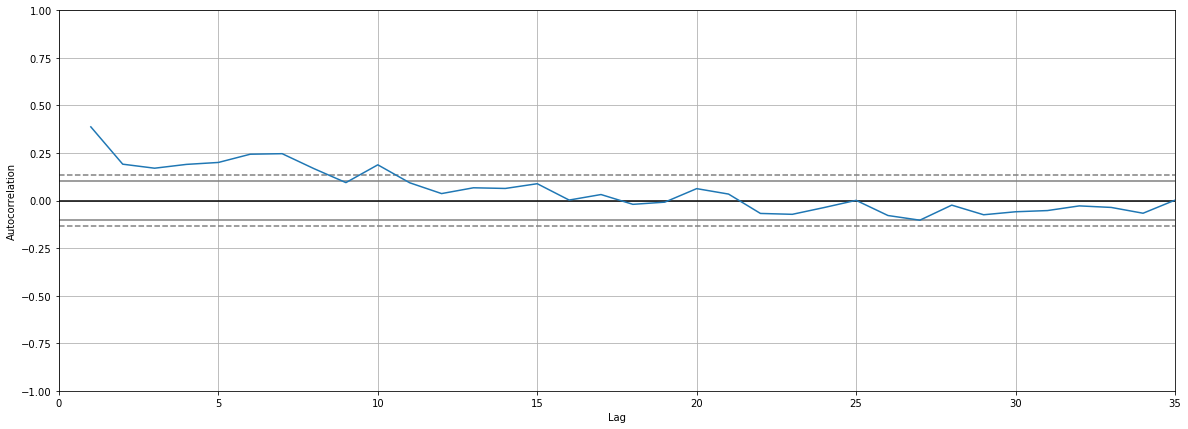

In [14]:
# plot autocorrelation for different lags using pandas
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(daily_average_delay)
plt.xlim(0,35);

## Weekly Average

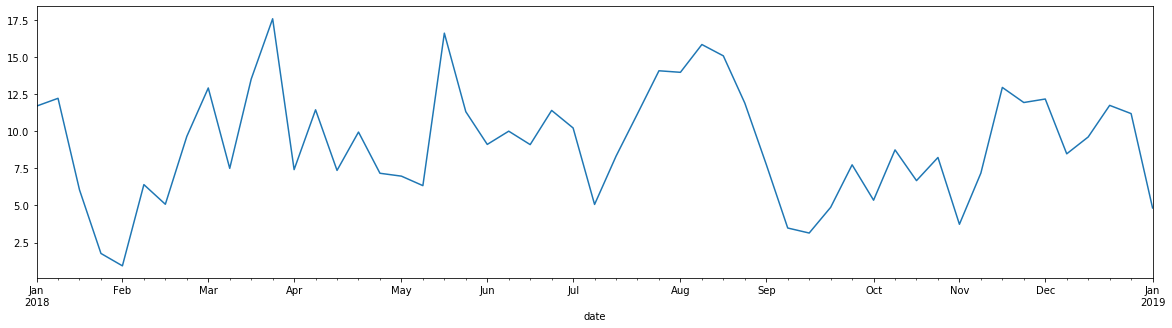

In [15]:
# resample original sales data total by week
weekly_average_delay = ca_df.dep_delay.resample('W').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

weekly_average_delay.plot(figsize=(20,5));

## Monthly Average

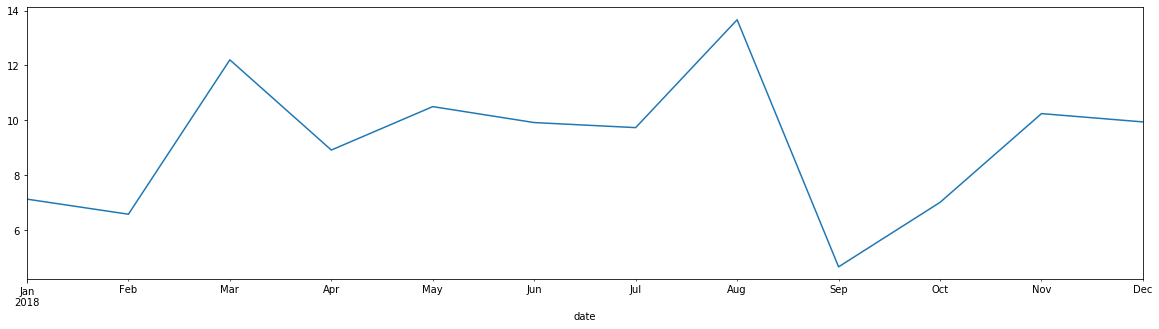

In [16]:
# resample original sales data total by week
monthly_average_delay = ca_df.dep_delay.resample('M').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

monthly_average_delay.plot(figsize=(20,5));

## Rolling Daily Mean

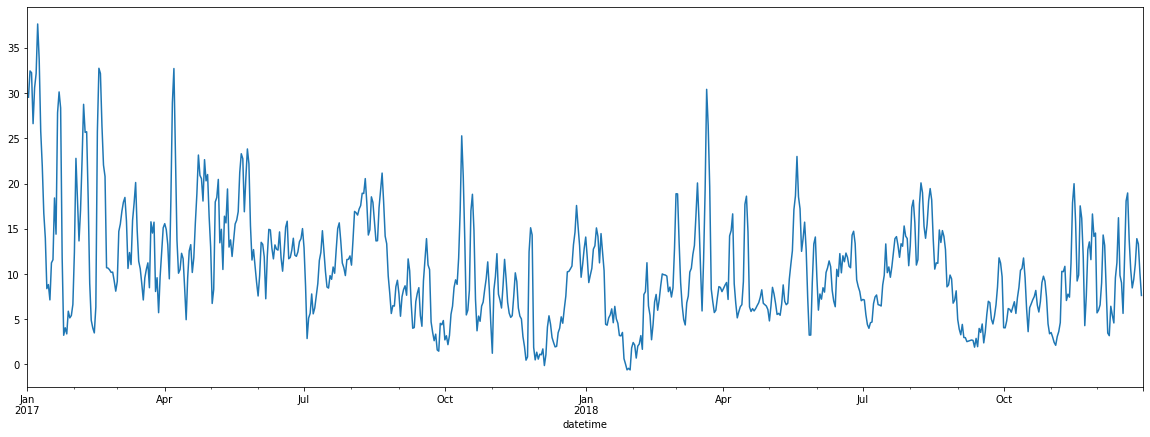

In [64]:
# find rolling daily mean
daily_avg_delay = ca_yrs_df.dep_delay.resample('D').mean()
daily_avg_delay.rolling(window=3, center=True).mean().plot(figsize=(20,7));

# this gives us a bit of smoothing to exclude extreme events

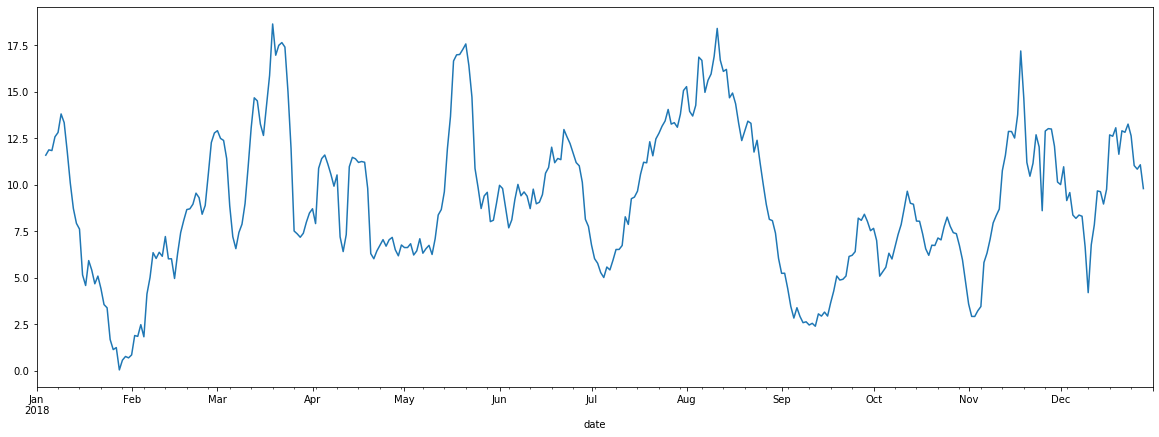

In [18]:
daily_average_delay.rolling(window=7, center=True).mean().plot(figsize=(20,7));

## Plot the distribution of delay by month

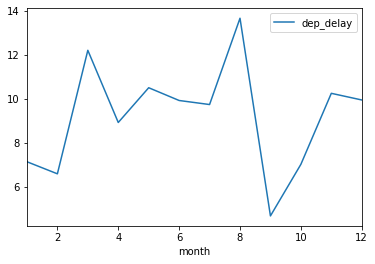

In [19]:
pt_m = ca_df.pivot_table(index = 'month',values='dep_delay')
pt_m.plot()

In [20]:
for i in [1,7,28]:
    print(i, daily_average_delay.autocorr(lag=i))

1 0.3880438484992574
7 0.24887158531769402
28 -0.026004388186862244


## Plot Delay by Carrier

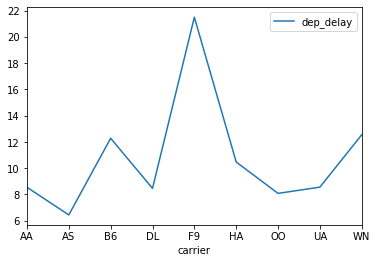

In [21]:
pt_carrier = ca_df.pivot_table(index = 'carrier',values='dep_delay')
pt_carrier.plot()

## Plot Delay by Origin

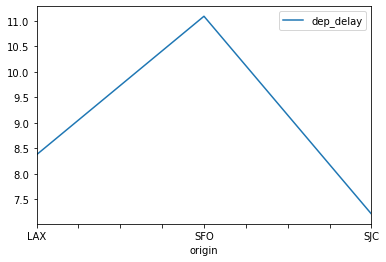

In [22]:
pt_origin = ca_df.pivot_table(index = 'origin',values='dep_delay')
pt_origin.plot()

# 2017 / 2018 DataFrame

In [23]:
with open('ca_yrs_df.pickle','rb') as read_file:
    ca_yrs_df = pickle.load(read_file)

In [24]:
# delay by full datetime (date + time)
#yrs_delay_df = ca_yrs_df[['datetime','dep_delay']]
ca_yrs_df.set_index('datetime',inplace=True)

In [140]:
carrier_df

carrier
F9    22.291535
B6    14.627792
WN    13.767687
DL    10.674496
OO    10.629196
HA     9.617638
UA     9.370854
AA     8.934160
AS     6.068398
Name: dep_delay, dtype: float64

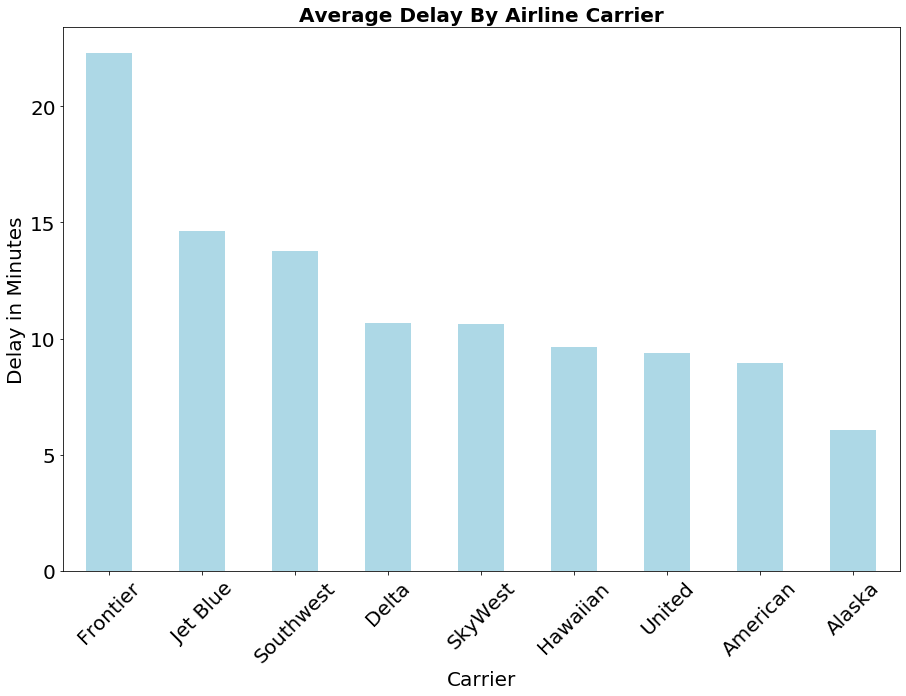

In [167]:
carrier_df = ca_yrs_df.groupby('carrier').dep_delay.mean().sort_values(ascending=False)
#pvt_carrier = ca_yrs_df.pivot_table(index='carrier',columns='carrier',values='dep_delay')
carrier_df.plot(kind='bar', figsize=(15,10), color='lightblue')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8],labels=['Frontier','Jet Blue','Southwest','Delta','SkyWest','Hawaiian','United','American','Alaska'],
          rotation=45)
plt.title('Average Delay By Airline Carrier', fontsize=20, weight='bold')
plt.xlabel('Carrier')
plt.ylabel('Delay in Minutes')
plt.rcParams.update({'font.size': 20})
plt.savefig('avgdelayCarrier.svg', format='svg', transparent=True)
plt.show()


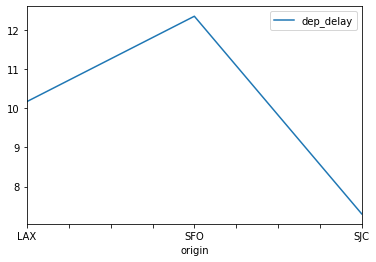

In [26]:
pvt_origin = ca_yrs_df.pivot_table(index = 'origin',values='dep_delay')
pvt_origin.plot()

## Daily Average Delay

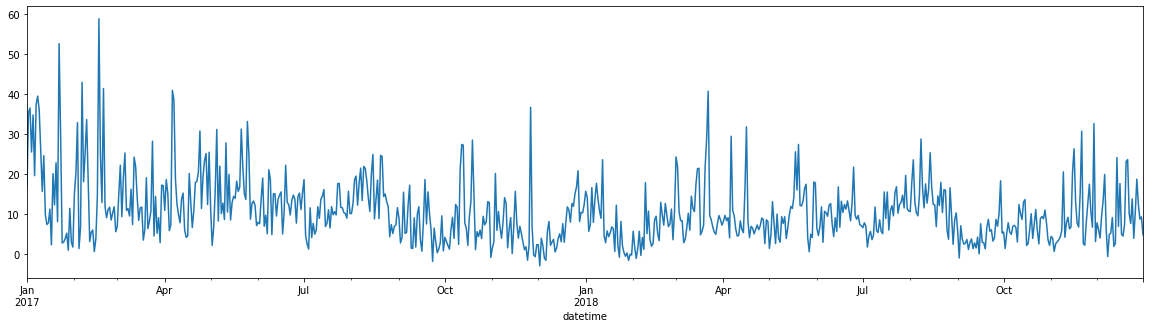

In [27]:
# resample original sales data total by day
daily_avg_delay = ca_yrs_df.dep_delay.resample('D').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

daily_avg_delay.plot(figsize=(20,5));

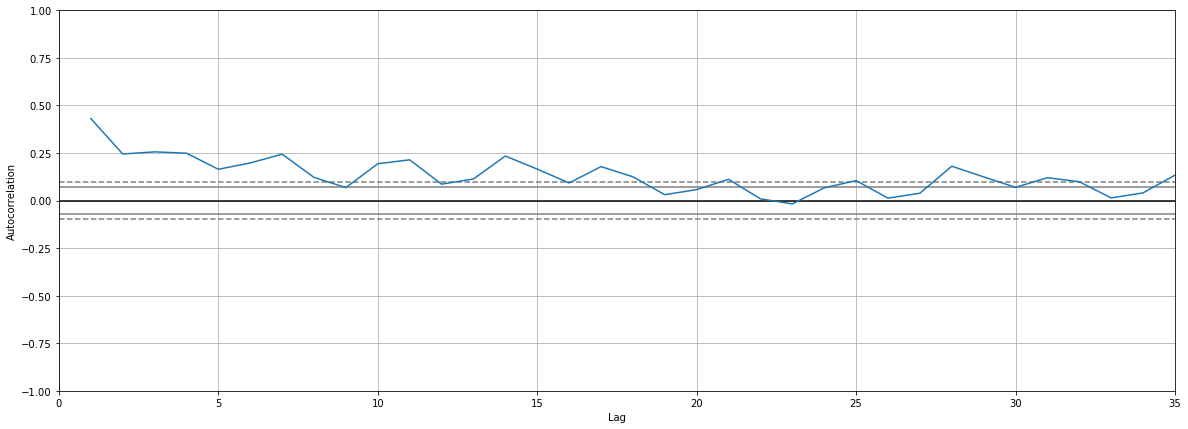

In [28]:
# plot 2017/2018 autocorrelation for different lags using pandas
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(daily_avg_delay)
plt.xlim(0,35);

## Weekly Average Delay

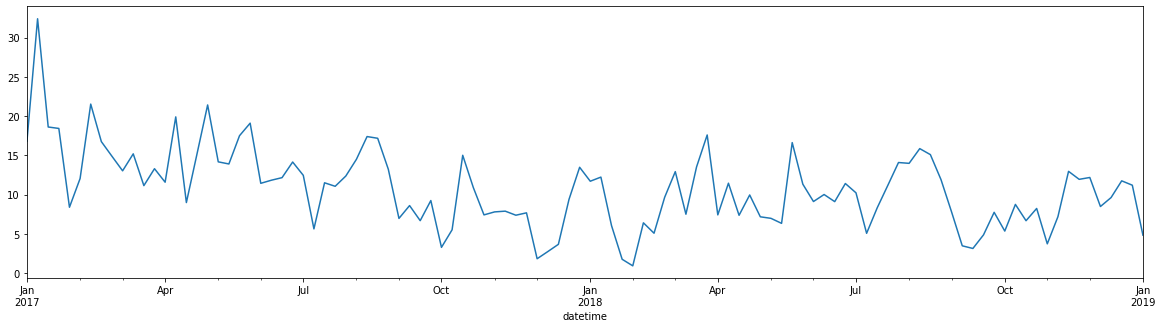

In [29]:
# resample original sales data total by month
weekly_avg_delay = ca_yrs_df.dep_delay.resample('W').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

weekly_avg_delay.plot(figsize=(20,5));

## Monthly Average Delay

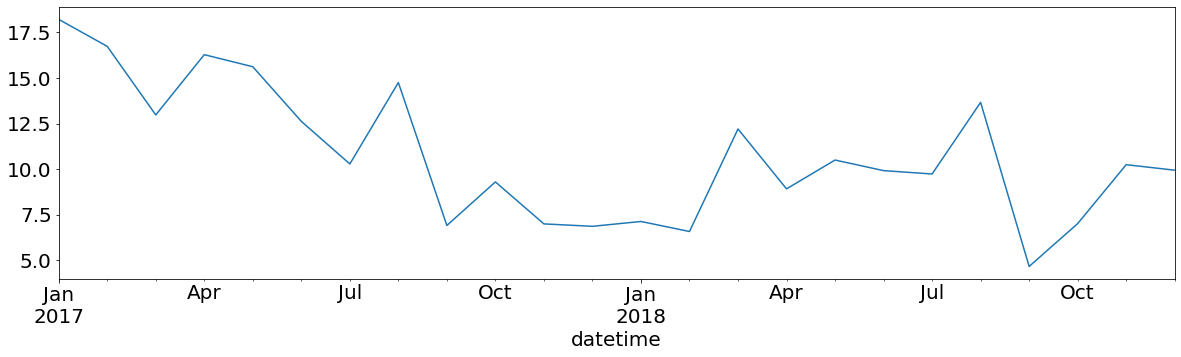

In [164]:
# resample original sales data total by month
monthly_avg_delay = ca_yrs_df.dep_delay.resample('M').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

monthly_avg_delay.plot(figsize=(20,5));

## Annual Average Delay

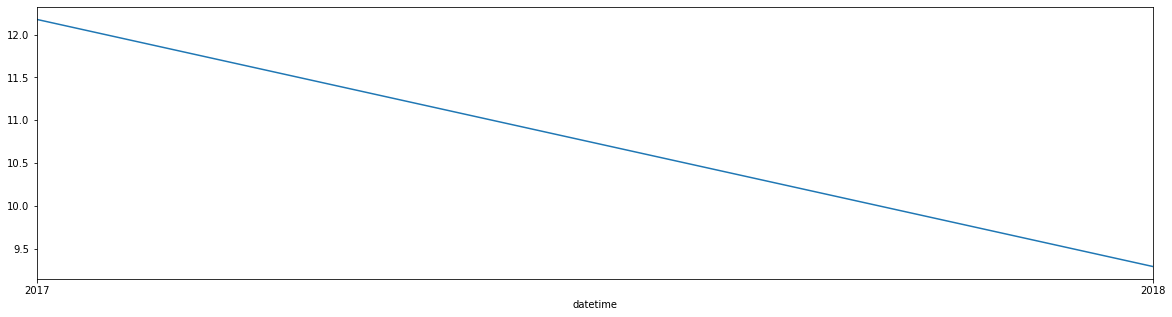

In [31]:
# resample original sales data total by month
annual_avg_delay = ca_yrs_df.dep_delay.resample('A').mean()
#mean is used for average sales across all stores
#sum would be used for total sales across stores

annual_avg_delay.plot(figsize=(20,5));

# Dickey-Fuller Method

In [33]:
# delay by date
only_delay = ca_df[['fl_date','dep_delay']]
only_delay['date'] = pd.to_datetime(ca_df['fl_date'])
only_delay.set_index('date', inplace=True)
monthly_delay = only_delay.resample('M').mean()
daily_delay = only_delay.resample('D').mean()


/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
# filter dataframe for only target = dep_delay
delay_df = ca_yrs_df[['dep_delay']]
daily_delay_df = delay_df.resample('D').mean()
hourly_delay_df = delay_df.resample('H').sum()
#tried to do sum instead of mean b/c of NaN for nulls
#hourly_delay_df.dropna(axis=0,inplace=True)

In [35]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

## DFT on 2018

Test Statistic           -3.768980
p-value                   0.003241
Lags Used                10.000000
Observations Used       354.000000
Critical Value (1%)      -3.448958
Critical Value (5%)      -2.869739
Critical Value (10%)     -2.571138
dtype: float64


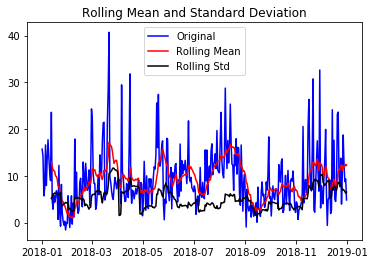

In [36]:
# run DFT on 2018 daily
dftest(daily_delay.dep_delay)
# p-value allows us to reject a unit root: data is stationary

## DFT on 2017/2018

Test Statistic           -4.571761
p-value                   0.000146
Lags Used                13.000000
Observations Used       716.000000
Critical Value (1%)      -3.439516
Critical Value (5%)      -2.865585
Critical Value (10%)     -2.568924
dtype: float64


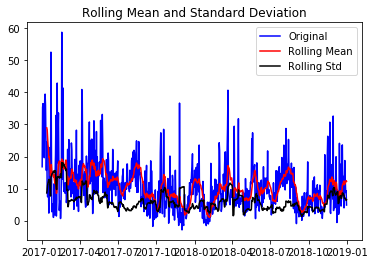

In [37]:
# 2017/2018 DFT daily test
# run DFT on daily
dftest(daily_delay_df.dep_delay)
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -1.348069e+01
p-value                 3.245746e-25
Lags Used               4.400000e+01
Observations Used       1.747500e+04
Critical Value (1%)    -3.430724e+00
Critical Value (5%)    -2.861705e+00
Critical Value (10%)   -2.566858e+00
dtype: float64


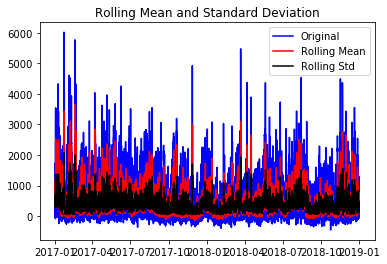

In [38]:
# run DFT on hourly 2017/2018
dftest(hourly_delay_df.dep_delay)
# p-value allows us to reject a unit root: data is stationary

## Plotting Helper Function

In [11]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

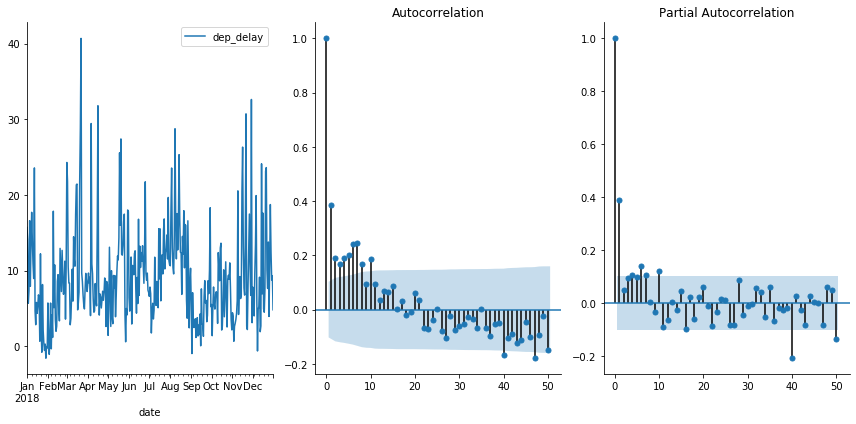

In [40]:
# helper plot for daily delay
plots(daily_delay, lags=50);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

# SARIMA

In [76]:
import statsmodels.api as sm

# fit SARIMA daily based on helper plots
sar_18 = sm.tsa.statespace.SARIMAX(np.log(daily_delay.dep_delay), order=(1,1,1), seasonal_order=(0,0,0,0), trend='n').fit()
sar_18.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              dep_delay   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -380.388
Date:                Thu, 23 Jan 2020   AIC                            766.777
Time:                        17:26:58   BIC                            778.468
Sample:                    01-01-2018   HQIC                           771.424
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1060      0.058      1.815      0.070      -0.008       0.221
ma.L1         -0.8090      0.035    -22.871      0.000      -0.878      -0.740
sigma2         0.4964      0.025     20.162      0.000       0.448       0.545
===================================================================================
Ljung-Box (Q):                       48.80   Jarque-Bera (JB):               190.58
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.77
Prob(H) (two-sided):                  0.25   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 1 . Find Lowest AIC with Order/Seasonal Order

In [59]:
pdq = [(1,0,0),(2,0,1),(1,0,1),(3,0,1)]
PQDs = [(1,0,1,7),(0,1,0,7)]
vars_list = []
for each in pdq:
    for i in range(0,2):
        s_order = PQDs[i]
        results = sm.tsa.statespace.SARIMAX(daily_delay_df.dep_delay, order = each, seasonal_order = s_order, trend='c').fit()
        score = results.aic
        print([each, s_order, score])
        
#         variable1 = each + PQDs[i]
#         vars_list.append(variable1)

/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 0), (1, 0, 1, 7), 4873.857665745685]
[(1, 0, 0), (0, 1, 0, 7), 5254.093423212917]


/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[(2, 0, 1), (1, 0, 1, 7), 4876.937349159945]
[(2, 0, 1), (0, 1, 0, 7), 5246.439821075857]


/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(1, 0, 1), (1, 0, 1, 7), 4867.739226246979]
[(1, 0, 1), (0, 1, 0, 7), 5255.363607201001]


/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


[(3, 0, 1), (1, 0, 1, 7), 4873.7095146797965]
[(3, 0, 1), (0, 1, 0, 7), 5257.872796665799]


# Step 2. KFold Cross Validation Score Compare

In [61]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)  #produce the k-folds object

for train_index, test_index in kf.split(X, y):  #loop over the set of fold-index pairs
    X_train, X_test = X[train_index], X[test_index]  #create training and test independent variable data
    y_train, y_test = y[train_index], y[test_index]  #create training and test dependent variable data

    kf_score = (results.predict(X_train))-y_train)
    kf_scores.append(kf_score)
    
print(np.mean(kf_scores),np.std(kf_scores))

In [51]:
sar_d_1718 = sm.tsa.statespace.SARIMAX(daily_delay_df.dep_delay, order=(1,0,0), seasonal_order=(0,1,0,7), trend='c').fit()
sar_d_1718.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         dep_delay   No. Observations:                  730
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood               -2624.047
Date:                           Thu, 23 Jan 2020   AIC                           5254.093
Time:                                   16:31:46   BIC                           5267.844
Sample:                               01-01-2017   HQIC                          5259.401
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1188      0.345     -0.344      0.731      -0.795       0.558
ar.L1          0.3397      0.031     11.073      0.000       0.280       0.400
sigma2        83.1564      2.451     33.929      0.000      78.353      87.960
===================================================================================
Ljung-Box (Q):                      271.41   Jarque-Bera (JB):               592.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
sar_h_1718 = sm.tsa.statespace.SARIMAX(hourly_delay_df.dep_delay, order=(1,0,0), seasonal_order=(0,1,0,7), trend='c').fit()
sar_h_1718.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         dep_delay   No. Observations:                17520
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 7)   Log Likelihood             -136440.939
Date:                           Thu, 23 Jan 2020   AIC                         272887.879
Time:                                   16:47:43   BIC                         272911.191
Sample:                               01-01-2017   HQIC                        272895.555
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0140      4.466      0.003      0.998      -8.739       8.767
ar.L1          0.7158      0.004    184.952      0.000       0.708       0.723
sigma2      3.424e+05   2330.303    146.948      0.000    3.38e+05    3.47e+05
===================================================================================
Ljung-Box (Q):                    11005.97   Jarque-Bera (JB):              6600.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
sar_h_18 = sm.tsa.statespace.SARIMAX(hourly_delay.dep_delay, order=(1,0,0), seasonal_order=(0,1,0,7), trend='c').fit()
sar_h_18.summary()

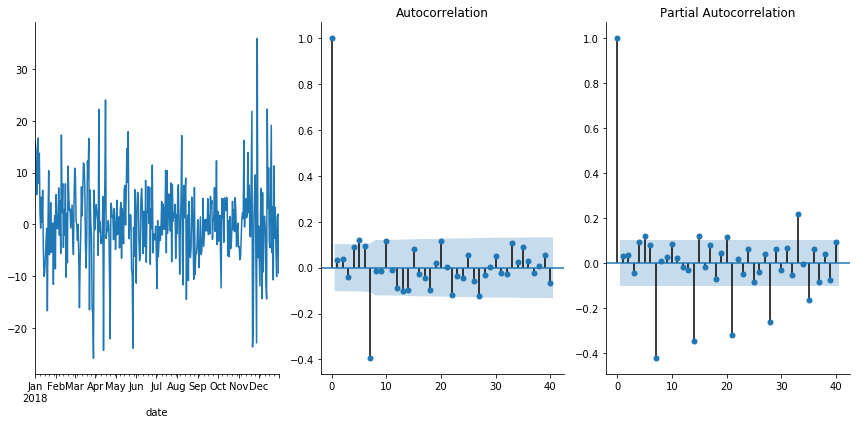

In [43]:
plots(sar_18.resid, lags=40);

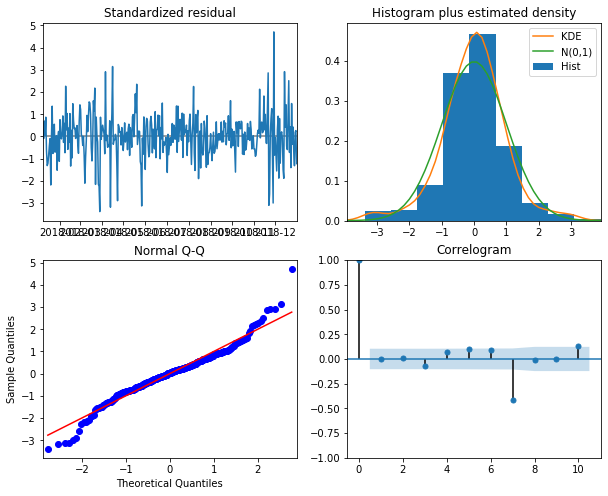

In [44]:
sar_18.plot_diagnostics(figsize=(10, 8));

In [8]:
weekly_delay_df = ca_yrs_df.resample('W').mean()

sar_w_1718 = sm.tsa.statespace.SARIMAX(np.log(weekly_delay_df),order=(0,1,1), 
                                seasonal_order=(0,1,0,52), 
                                trend='n').fit()
sar_w_1718.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          dep_delay   No. Observations:                  106
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 52)   Log Likelihood                 -46.357
Date:                            Fri, 24 Jan 2020   AIC                             96.714
Time:                                    09:04:51   BIC                            100.655
Sample:                                01-01-2017   HQIC                            98.229
                                     - 01-06-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2930      0.134     -2.186      0.029      -0.556      -0.030
sigma2         0.3361      0.064      5.212      0.000       0.210       0.463
===================================================================================
Ljung-Box (Q):                       39.10   Jarque-Bera (JB):                 1.78
Prob(Q):                              0.51   Prob(JB):                         0.41
Heteroskedasticity (H):               1.35   Skew:                             0.44
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


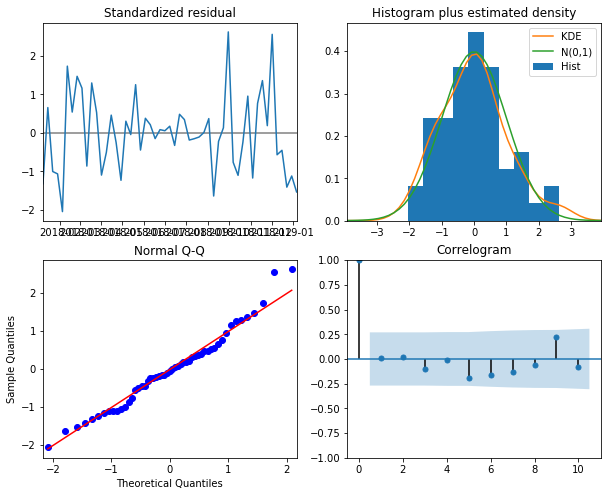

In [9]:
sar_w_1718.plot_diagnostics(figsize=(10, 8));

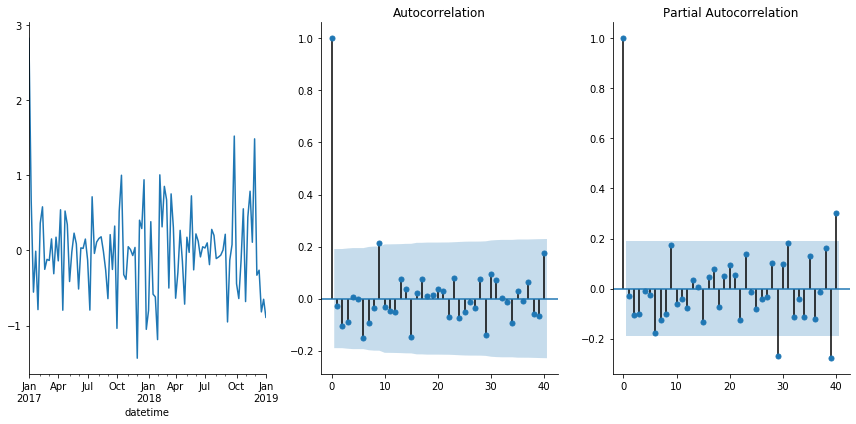

In [12]:
plots(sar_w_1718.resid, lags=40);

## Prediction Model

/Users/KC/miniconda3/envs/metis/lib/python3.7/site-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


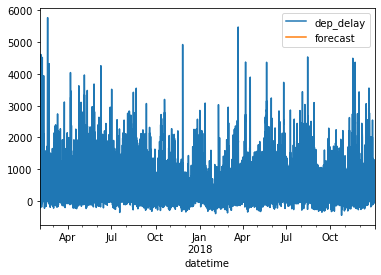

In [47]:
hourly_delay_df['forecast'] = sar_18.predict(start = 750, end= 10000,dynamic=30)  
hourly_delay_df[750:][['dep_delay','forecast']].plot();

In [ ]:
sar_d_1718.plot_diagnostics(figsize=(10, 8));